### Data &/ Files

In [1]:
train = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/train'
test = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/test'
val = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/valid'

### Resnet 50

In [2]:
 # display, transform, read, split ...
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50, ResNet152V2, ResNet50V2, InceptionV3, InceptionResNetV2, ConvNeXtXLarge
from tensorflow.keras.applications.resnet50 import preprocess_input

#### Data Loaders

In [3]:
class_names = ['adenocarcinoma', 'large cell carcinoma', 'normal', 'squamous cell carcinoma']

In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Apply random shear transformations
    zoom_range=0.2,         # Apply random zoom transformations
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill missing pixels with the nearest available pixel
)

In [5]:
# training data
train_generator = datagen.flow_from_directory(
    directory = train,
    classes = class_names,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse",
)

Found 611 images belonging to 4 classes.


In [6]:
# test data
test_generator = datagen.flow_from_directory(
    directory = test,
    classes = class_names,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse",
)

Found 315 images belonging to 4 classes.


In [7]:
# validation data
valid_generator = datagen.flow_from_directory(
    directory = val,
    classes = class_names,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse",
)

Found 72 images belonging to 4 classes.


In [8]:
print(valid_generator.class_indices)
print(valid_generator.class_mode)

{'adenocarcinoma': 0, 'large cell carcinoma': 1, 'normal': 2, 'squamous cell carcinoma': 3}
sparse


#### Building the Model

In [10]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
#resnet_50 = ConvNeXtXLarge(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [11]:
# build the entire model
x = resnet_50.output

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(4, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

#### Training

In [13]:
# define training function
def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data = test_generator, epochs=epochs, batch_size=batch_size)

In [14]:
# launch the training
history = trainModel(model = model, epochs = 30, optimizer = "Adam")

Epoch 1/30
20/20 [==============================] - 35s 1s/step - loss: 2.4922 - accuracy: 0.2635 - val_loss: 1.3839 - val_accuracy: 0.2984
Epoch 2/30
20/20 [==============================] - 17s 874ms/step - loss: 1.6107 - accuracy: 0.2848 - val_loss: 1.3514 - val_accuracy: 0.3175
Epoch 3/30
20/20 [==============================] - 17s 906ms/step - loss: 1.4601 - accuracy: 0.3208 - val_loss: 1.2662 - val_accuracy: 0.4762
Epoch 4/30
20/20 [==============================] - 22s 1s/step - loss: 1.3133 - accuracy: 0.3666 - val_loss: 1.1866 - val_accuracy: 0.4508
Epoch 5/30
20/20 [==============================] - 17s 855ms/step - loss: 1.2105 - accuracy: 0.4468 - val_loss: 1.0319 - val_accuracy: 0.5429
Epoch 7/30
20/20 [==============================] - 18s 909ms/step - loss: 1.2070 - accuracy: 0.4566 - val_loss: 1.0459 - val_accuracy: 0.5492
Epoch 8/30
20/20 [==============================] - 17s 855ms/step - loss: 1.1820 - accuracy: 0.4255 - val_loss: 1.0442 - val_accuracy: 0.5492
Epoch

#### Loss & Accuracy Curves

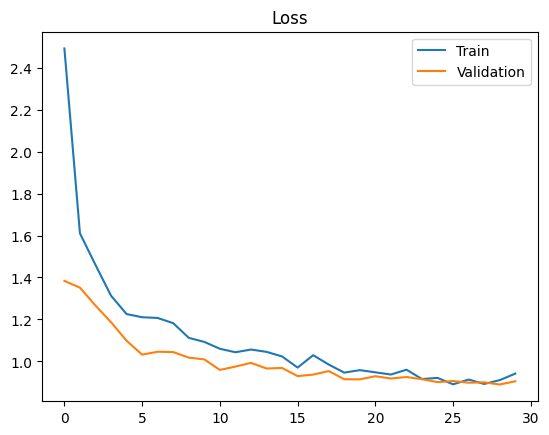

In [15]:
loss_train_curve = history.history["loss"]
loss_val_curve = history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

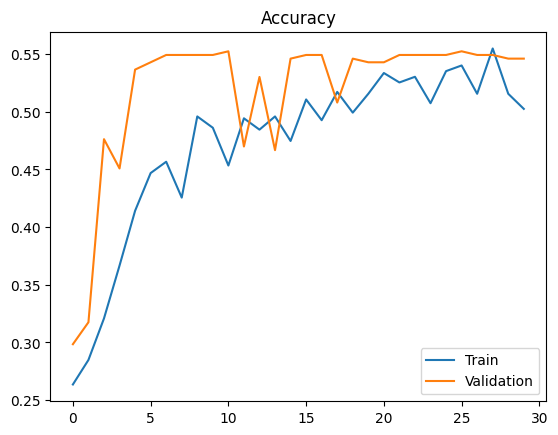

In [16]:
acc_train_curve = history.history["accuracy"]
acc_val_curve = history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

#### Eavluation

In [17]:
'''
when using val data in model.fit:
    The test loss is:  0.9591650366783142
    The best accuracy is:  54.92063760757446
'''

'''
ConvNeXtXLarge
The test loss is:  0.9080061316490173
The best accuracy is:  50.0
'''


test_loss, test_acc = model.evaluate(valid_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

3/3 [==============================] - 3s 848ms/step - loss: 0.9847 - accuracy: 0.4861
The test loss is:  0.9846965074539185
The best accuracy is:  48.61111044883728


#### New images

In [18]:
adenocarcinoma = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/valid/adenocarcinoma/000109 (8).png'
large_cell_carcinoma = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/valid/large cell carcinoma/000120.png'
normal = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/valid/normal/5.png'
squamous_cell_carcinoma = '/content/drive/MyDrive/IS Drafts/B. Yuda/Chest CT/valid/squamous cell carcinoma/000111.png'

In [19]:
test_images = [
    adenocarcinoma,
    large_cell_carcinoma,
    normal,
    squamous_cell_carcinoma
]

In [ ]:
img = tf.keras.preprocessing.image.load_img(test_images[2], target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array])
img

In [21]:
def pred(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.array([img_array])

    # generate predictions for samples
    predictions = model.predict(img_array)

    # generate argmax for predictions
    class_id = np.argmax(predictions, axis = 1)

    # transform classes number into classes name
    return class_names[class_id.item()]
    #print(class_id)
    #print(predictions)


In [22]:
for i in test_images:
    #print("Actual Label should be: " + str(i))
    print(pred(i))
    print('--' * 30)

1/1 [==============================] - 1s 1s/step
adenocarcinoma
------------------------------------------------------------
1/1 [==============================] - 0s 24ms/step
adenocarcinoma
------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step
normal
------------------------------------------------------------
1/1 [==============================] - 0s 23ms/step
adenocarcinoma
------------------------------------------------------------


#### Deployment

In [ ]:
#model.save('/resnet_model')

In [23]:
model.save('resnet_model.keras')

In [ ]:
%ls /resnet_model

In [ ]:
loaded_model = tf.keras.models.load_model('/resnet_model')
loaded_model.summary()